# Advanced Monte Carlo Methods for Bayesian Inference

This notebook containes all the Python code used in Chapter 5: Advanced Monte Carlo Methods for Bayesian Inference. Below, we shall explore how to implement MCMC and SMC algorithms to perform Bayesian Inference, we will focus on how to estimate model parameters and hidden state values.

**Index:**
* [Markov Chain Monte Carlo](#markov-chain-monte-carlo)
* [Sequential Monte Carlo](#sequential-monte-carlo)

In [83]:
#Import all libraries
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.legend_handler import HandlerPathCollection

## Markov Chain Monte Carlo

Let us assume we are interested in estimating the bias of a coin, represented by the probability $\theta$ that the coin will land on heads. Initially, we assumed that the coin was unbiased ($\theta = 0.5$). However, after launching the coin $20$ times, $15$ tosses resulted in heads. Taking into account our prior belief and the data, what will be the posterior probability distribution for the bias of the coin?

If we consider each individual coin flip independently, we can model the probability that the coin lands in heads through a Bernoulli distribution with parameter $\theta$. In addition, if we assign $\theta$ the $\beta(10,10)$ prior distribution, all that is left is to compute the posterior distribution for the coin's bias.

$$
p(\theta | x_{1:20}) = \frac{p(x_{1:20}| \theta) p(\theta)}{\int p(x_{1:20} | \theta) p(\theta) d\theta }
$$


By definition, we know that
\begin{align*}
p(\theta) & = \frac{1}{\beta(10,10)} \theta^{10-1}(1-\theta)^{10-1} \\
 & = \frac{1}{\beta(10,10)} \theta^{9}(1-\theta)^{9}
\end{align*}
and
\begin{align*}
p(x_{1:20}| \theta) & = \prod_{i=1}^{20} \theta^{x_i}(1-\theta)^{1-x_i} \\
 & = \theta^{15}(1-\theta)^5
\end{align*}
where $x_i = 1$ when the coin lands in heads and $x_i = 0$ when it lands in tails. 

Substituting back into our posterior, and using $p(\theta | x_{1:20}) \propto p(x_{1:20}| \theta) p(\theta)$ it results that
\begin{align*}
p(\theta | x_{1:20}) \propto \frac{1}{\beta(10)(10)} \theta^{24}(1-\theta)^{14}.
\end{align*}
Fortunately, we can analytically obtain our marginal likelihood through
\begin{align*}
\int_0^1 p(x_{1:20} | \theta) p(\theta) d\theta &= \int_0^1  \frac{1}{\beta(10)(10)} \theta^{24}(1-\theta)^{14} d\theta \\
 &= \frac{\beta(25,15)}{\beta(10)(10)} \int_0^1 \frac{1}{\beta(25,15)}\theta^{24}(1-\theta)^{14} d\theta \\
 &= \frac{\beta(25,15)}{\beta(10)(10)}
\end{align*}

With this in mind, we can conclude that $\theta | X \sim \beta(25,15)$ and the posterior mean is given by
$$
\mathbb{E}[\theta | X] = \frac{\alpha}{\alpha + \beta} = \frac{25}{40} = 0.625. 
$$
In this example, the prior and likelihood distributions were carefully chosen to be conjugate, allowing the posterior distribution to have a closed analytical form. In practice, this is rare, and it is necessary to rely on MCMC techniques to approximate the posterior numerically. We can now rely on the Metropolis-Hastings algorithm to validate that we get a consistent result.

In [3]:
# Lets create a np.array with our observed data x_i
num_tosses = 20
num_heads = 15

data = np.array([1] * num_heads + [0] * (num_tosses - num_heads))
np.random.shuffle(data)

# We can define the prior and likelihood distributions
def prior(x):
    alpha = 10
    beta =10 
    return stats.beta(alpha,beta).pdf(x)

def likelihood(theta, data):
    trials = len(data)
    heads = data.sum()
    return theta**heads * (1-theta)**(trials - heads)

# Apply MH MCMC to estimate the posterior distribution
num_chains = 4 
num_iterations = 8000
burnin = 2000
chain_length = num_iterations + burnin

theta = np.zeros(num_iterations+burnin)
theta[0] = stats.beta(10,10).rvs(1)[0]

chains = np.zeros((num_chains, chain_length))

for chain_index in range(num_chains):
    chains[chain_index][0] = stats.uniform(0,1).rvs()
    
    # Generate chain samples
    for t in range(1, chain_length):
        theta_new = stats.norm(chains[chain_index][t-1], 0.05).rvs()
        prior_ratio = prior(theta_new) / prior(chains[chain_index][t-1])
        like_ratio = likelihood(theta_new, data) / likelihood(chains[chain_index][t-1], data)
        acceptance_ratio = min(1, prior_ratio * like_ratio)

        u = stats.uniform(0, 1).rvs()
        if u <= acceptance_ratio:
            chains[chain_index][t] = theta_new
        else:
            chains[chain_index][t] = chains[chain_index][t-1]

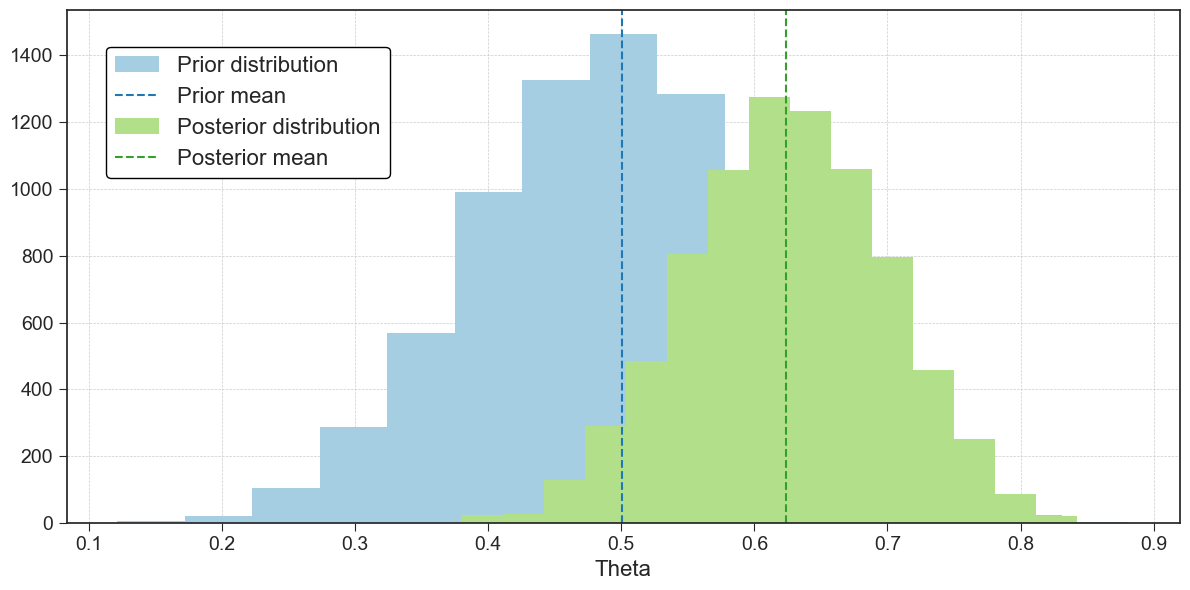

Posterior mean: 0.624


In [4]:
# Show the plot for the prior and posterior distributions
prior_values = stats.beta(10,10).rvs(8000)

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.hist(prior_values, bins = 15, color = colors[0], label='Prior distribution')
plt.axvline(x=np.mean(prior_values), color=colors[1], linestyle='--', label='Prior mean')

plt.hist(chains[0,burnin:], bins = 15, color = colors[2], label='Posterior distribution')
plt.axvline(x=np.mean(chains[0,burnin:]), color=colors[3], linestyle='--', label='Posterior mean')

plt.xlabel('Theta', fontsize=16)

plt.legend(
    bbox_to_anchor=(0.3, 0.95),
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

print('Posterior mean: {:.3f}'.format(np.mean(chains[0, burnin:])))

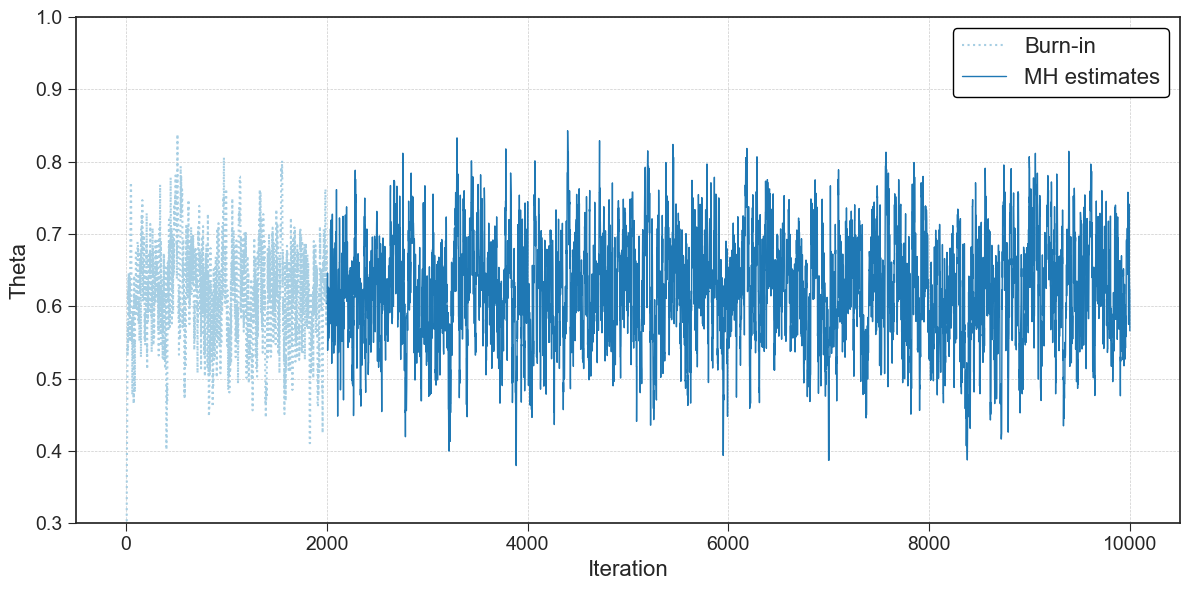

In [5]:
# Show trace plot for the first chain
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

# Plot the burn-in period in a different color
plt.plot(np.arange(burnin), chains[0,: burnin], color=colors[0], label='Burn-in', linewidth=1.5, linestyle=':')

# Plot the remaining iterations after burn-in in blue
plt.plot(np.arange(burnin, num_iterations + burnin), chains[0,burnin:], color=colors[1], label='MH estimates', linewidth=1)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Theta', fontsize=16)
plt.ylim(0.3,1)
plt.legend(
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')
plt.tick_params(axis='both', which='major', labelsize=14)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

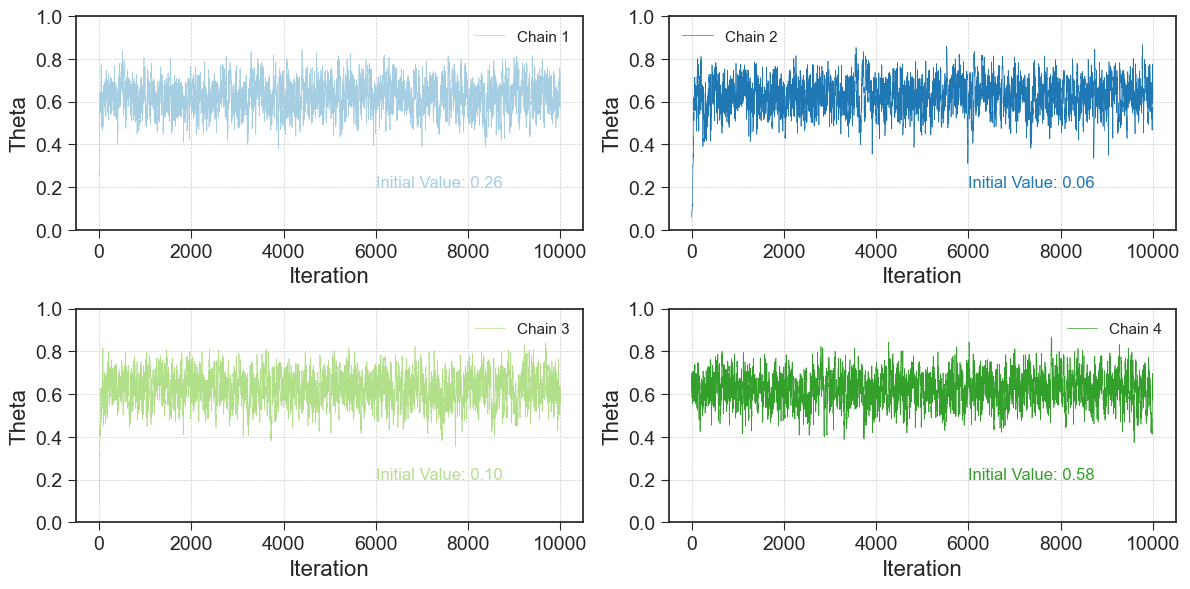

In [130]:
# Compare trace plots of each chain
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')
color_map = {0: 1, 1: 3, 2: 5, 3: 7}

for chain_index in range(num_chains):
    plt.subplot(2, 2, chain_index+1)
    plt.plot(chains[chain_index], label=f'Chain {chain_index+1}', color=colors[chain_index], linewidth=0.5)
    plt.text(6000, 0.2, f'Initial Value: {chains[chain_index][0]:.2f}', color=colors[chain_index], fontsize=12)
    plt.grid(visible=True, linestyle='--', linewidth=0.5)  
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('Theta',fontsize=16)
    plt.ylim(0, 1)
    plt.legend(fontsize=11)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    
plt.show()

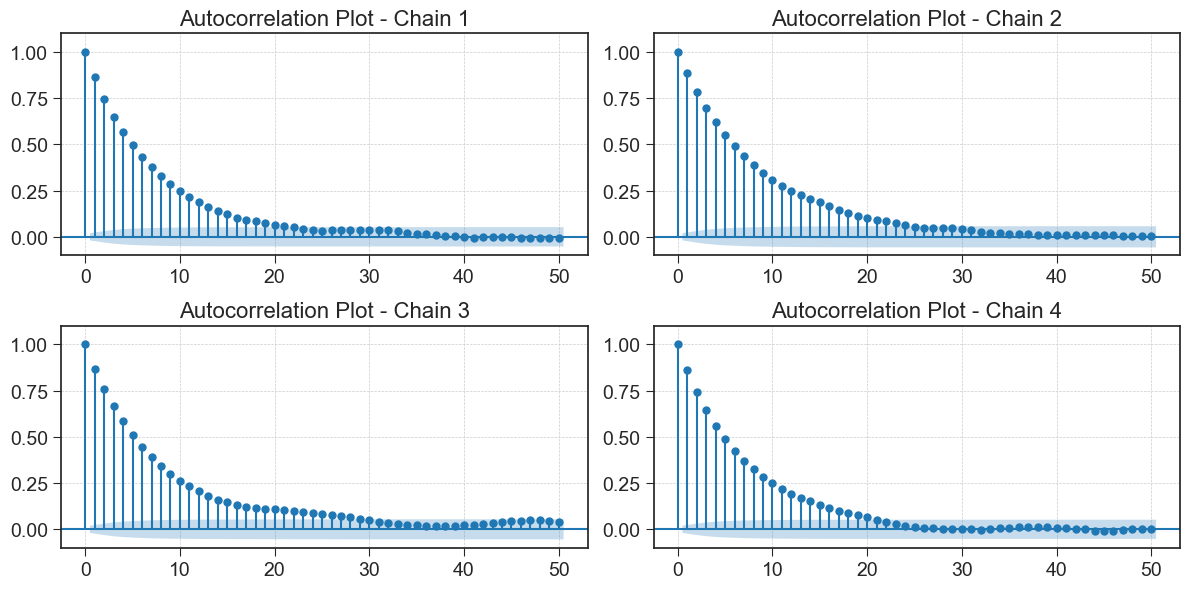

In [7]:
# Compute autocorrelation plots for each chain 

fig, axs = plt.subplots(2, 2, figsize=(12,6))  
axs = axs.flatten() 

for chain_index in range(num_chains):
    ax = axs[chain_index]
    sm.graphics.tsa.plot_acf(chains[chain_index], lags=50, ax=ax) 
    ax.set_title(f'Autocorrelation Plot - Chain {chain_index + 1}', fontsize=16)
    ax.set_ylim(-0.1, 1.1) 
    ax.grid(visible=True, linestyle='--', linewidth=0.5)  
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

plt.show()


In [8]:
def gelman_rubin(chains, burnin):
    K, L = chains.shape
    chains_L = chains[:, burnin:]
    
    chain_means = np.mean(chains_L, axis=1)
    overall_mean = np.mean(chain_means)
    
    # Between-chain variance
    B = (L / (L - 1)) * np.sum((chain_means - overall_mean) ** 2)
    
    # Within-chain variance
    W = (1 / K) * np.sum(np.var(chains, axis=1, ddof=1))
    
    # Estimate of marginal posterior variance
    V_hat = (L-1)/(L) * W + (B / L)
    
    # Potential Scale Reduction Factor
    R_hat = np.sqrt(V_hat / W)
    
    return R_hat

In [9]:
R_hat = gelman_rubin(chains, burnin)
print(f"Gelman-Rubin statistic (R-hat): {R_hat}")

Gelman-Rubin statistic (R-hat): 0.999950085217552


## Sequential Monte Carlo

In this section, we explore how to use different SMC algorithms to estimate the hidden state values of a HMM. As an example, let us use [George Deligiannidis](https://www.stats.ox.ac.uk/~deligian/pdf/sc5/notes/notes8.pdf) problem exercise in which we are trying to estimate the trajectory of a HMM that follows a random walk behavior given by 
\begin{align*}
x_1 &\sim N(0,1), \\
x_t | x_{t-1} &\sim N(0.95x_{t-1}, 1), \quad t > 1\\
y_t | x_t &\sim N(x_t,1), \quad t > 1.
\end{align*}

Without a loss of generality, let us generate the data from the random walk process described above.

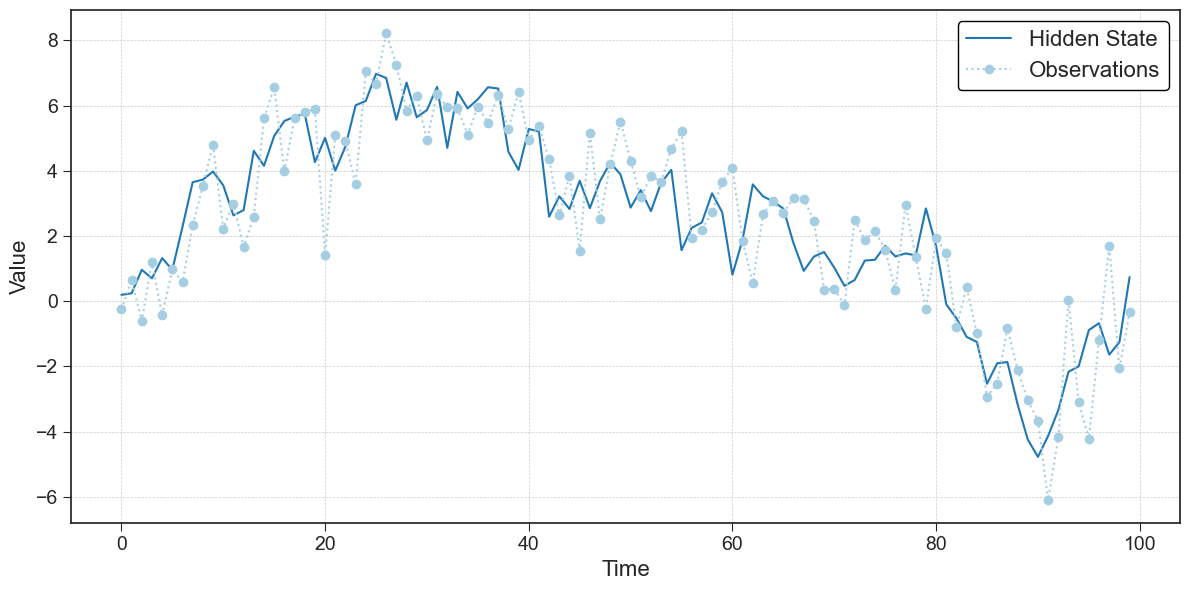

In [75]:
# Define parameters
alpha = 0.95
sigma_v = 1.0
sigma_w = 1.0

T = 100 # Define the number of time steps
time = np.arange(T) # Create a time vector 

# Hidden States Process
def f(x):
    return alpha*x + np.random.normal(0, sigma_v)

# Likelihood
def g(x):
    return x + np.random.normal(0, sigma_w)

# Observations
X_real = np.zeros(T)
Y_obs = np.zeros(T)
X_real[0] = np.random.normal(0, 1)
Y_obs[0] = g(X_real[0])
for t in range(1, T):
    X_real[t] = f(X_real[t-1])
    Y_obs[t] = g(X_real[t-1])

# Plot the hidden states and observations
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(time, X_real, label='Hidden State', color=colors[1])
plt.plot(time, Y_obs, marker='o', linestyle=':', label='Observations', color=colors[0])

plt.ylabel('Value', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(
    loc = 'upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

### Sequential Importance Sampling

We can now apply the SIS particle filter to estimate the expected value for the posterior distribution of our model and construct confidence bounds arround our hidden state estimates.

In [77]:
################################################
### Sequential Importance Sampling Algorithm ###
################################################

# Define number of particles
num_particles = 50
# Initialize varibles
weights = np.zeros((num_particles, T))
norm_weights = np.zeros((num_particles, T)) 
particles = np.zeros((num_particles,T))
#Initialize ESS
ESS = np.zeros(T)
#Initialize estimated states

estimated_states_SIS = np.zeros(T)
estimated_log_marginals_SIS = np.zeros(T)

# Time t=1
particles[:,0] = stats.norm(0,1).rvs(size=num_particles)
weights[:,0] = stats.norm(particles[:,0],1).pdf(Y_obs[0])
norm_weights[:,0] = weights[:,0] / weights[:,0].sum()

ESS[0] = 1 / (norm_weights[:,0]**2).sum()

estimated_states_SIS[0] = np.sum(particles[:, 0]*norm_weights[:,0])
estimated_log_marginals_SIS[0] = np.log(np.sum(weights[:,0])) - np.log(num_particles)

# Time t > 1
for t in range(1,T):
    # Predict step: propagate particles forward using motion model
    particles[:, t] = 0.95*particles[:, t - 1] + stats.norm(0,1).rvs(num_particles)

    # Update step: compute importance weights based on observation model
    incremental_weight = stats.norm(particles[:,t],1).pdf(Y_obs[t])
    weights[:, t] = weights[:, t-1]*incremental_weight  
    norm_weights[:, t] = weights[:,t] / weights[:,t].sum()
    
    ESS[t]= 1 / np.sum(norm_weights[:,t]**2)

    # Compute estimated state (weighted mean of particles)
    estimated_states_SIS[t] = np.sum(particles[:, t]*norm_weights[:,t])
    estimated_log_marginals_SIS[t] = np.log(np.sum(weights[:,t])) - np.log(num_particles)

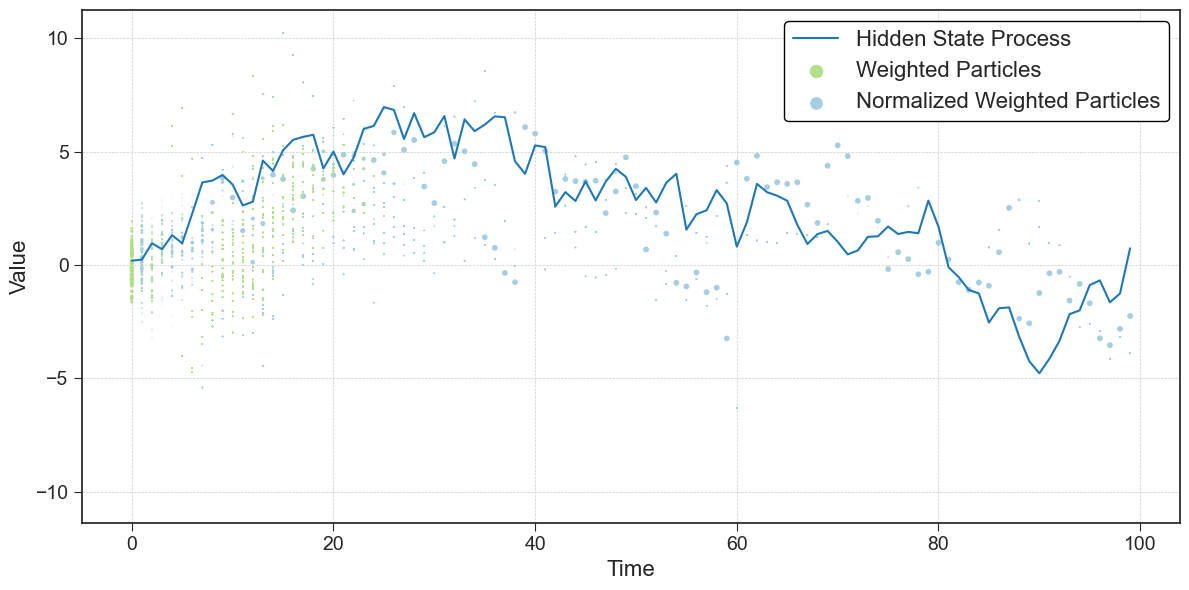

In [101]:
# Plot SIS weighted particles vs hidden state process

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(X_real, color=colors[1], label='Hidden State Process')

for t in range(T):
    if t == 1: 
        plt.scatter([t] * particles.shape[0], particles[:, t], s=weights[:, t]*10, marker='o', color=colors[2], label='Weighted Particles')
        plt.scatter([t] * particles.shape[0], particles[:, t], s=norm_weights[:, t]*30, marker='o', color=colors[0], label='Normalized Weighted Particles')
    else:
        plt.scatter([t] * particles.shape[0], particles[:, t], s=norm_weights[:, t]*10, marker='o', color=colors[0])
        plt.scatter([t] * particles.shape[0], particles[:, t], s=weights[:, t]*10, marker='o', color=colors[2])
        
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=10)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

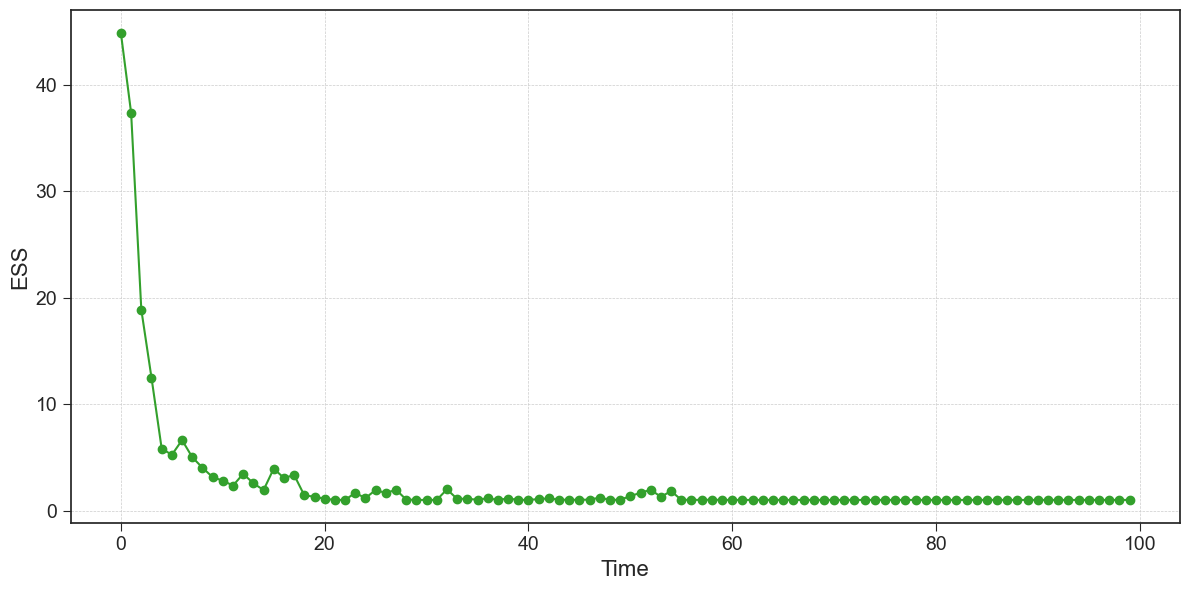

In [14]:
# Plot the ESS for the SIS results
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(ESS, color=colors[3], marker='o')
        
plt.xlabel('Time', fontsize=16)
plt.ylabel('ESS', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

### Systematic Resampling

Due to particle degeneracy issues, our SIS approximation for the practice problem is not that good. To mitigate this issue, we can turn to the Bootstrap Particle Filter to reintroduce particle diversity in each timestep. In this section we define the Systematic Resampling function that will allow us to resample each particle according to its weight and keep track of its ancestry path.

In [15]:
# Generate random starting position separadetly for comparability
r = stats.uniform(0,1).rvs()

In [16]:
# Systematic Resampling Algorithm
num_particles = len(particles[:,0])
weights_sum = np.cumsum(norm_weights[:,0])

# Step 1: generate positions
positions =  (np.arange(num_particles) + r)/num_particles


# Step 2: count number of positions within each weight
repeat_counts = np.zeros(num_particles)
repeat_counts[0] = np.sum(positions <= weights_sum[0])
for i in range(1,num_particles):
    repeat_counts[i] = np.sum((positions <= weights_sum[i])&(positions > weights_sum[i-1]))

# Step 3: resampling move
resampled_particles = np.repeat(particles[:,0],repeat_counts.astype(int))

print(repeat_counts)
print(resampled_particles)

[2. 0. 2. 1. 1. 2. 0. 1. 1. 1. 1. 1. 1. 2. 1. 0. 1. 1. 1. 2. 1. 0. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 2. 0. 1. 2. 1. 1. 1. 0. 1. 1.
 1. 0.]
[ 0.13691275  0.13691275 -0.26229355 -0.26229355  0.06463475 -0.14830078
  0.06529091  0.06529091 -0.89321067 -0.49866474  1.51018092 -0.01337382
  0.26109085  0.66642348 -0.29533756 -0.29533756 -0.32565168 -0.99158155
 -0.16848292 -0.68503065 -0.27832709 -0.27832709 -0.36223383  0.26685969
  0.26685969  0.70447784  0.63630183 -0.45644342  0.78565253 -0.33259426
  0.94908867 -0.22264992 -1.14476358  0.27261786 -1.31737872  0.35564039
  0.76007062  1.02012091 -0.20864047 -0.05945976 -0.05945976  0.4296675
 -0.08014387 -0.08014387 -0.50241526  0.29182915 -0.18793539 -0.18092003
 -1.00480025  1.0515717 ]


Alternatively, we can use the `np.searchsorted()` function in python with actually returns the ancestry matrix of the resampled particles instead of the resampling count. To keep track of the particle lineage this will be the prefered approach.

In [17]:
num_particles = len(particles[:,0])

# Step 1: generate positions
positions =  (np.arange(num_particles) + r )/num_particles

# Step 2: generate ancestry matrix
resample_indices = np.searchsorted(np.cumsum(norm_weights[:,0]), positions)

# Step 3: resampling move
resampled_particles_2 = particles[0,:][resample_indices]

print(resample_indices)
print(resampled_particles_2)



[ 0  0  2  2  3  4  5  5  7  8  9 10 11 12 13 13 14 16 17 18 19 19 20 22
 22 23 24 25 26 27 28 29 30 31 32 34 35 36 37 38 38 40 41 41 42 43 44 46
 47 48]
[ 1.36912747e-01  1.36912747e-01  3.37320439e-01  3.37320439e-01
  1.54907821e+00  8.95029335e-01  1.01064149e+00  1.01064149e+00
 -2.39758932e-01 -1.74942400e+00 -9.07996298e-01 -9.92600357e-02
  1.05345258e+00 -2.56151114e-02 -5.15051616e-01 -5.15051616e-01
  9.77731532e-01  3.43231711e+00  5.18629891e+00  4.19175042e+00
  5.57640258e+00  5.57640258e+00  4.52964475e+00  2.60604354e+00
  2.60604354e+00  1.36856735e+00  5.48061605e-01  3.40881978e-03
 -8.40619787e-01 -7.61567695e-01 -1.30180100e-01 -3.19215503e-01
 -7.05559420e-01 -7.74016785e-01  4.07301195e-02  1.45549649e-01
 -3.89018316e-01  9.50329983e-01  1.26725909e+00  1.85397547e-01
  1.85397547e-01 -9.92421346e-01 -1.59092396e+00 -1.59092396e+00
 -3.25131174e+00 -3.12876637e+00 -3.40611931e+00 -4.50189358e+00
 -6.84438821e+00 -7.35567002e+00]


In [18]:
resampled_particles == resampled_particles_2

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [19]:
# Define Systematic Resampling Function
def systematic_resampling(particles, norm_weights):
    n = len(particles)
    
    # Step 1: generate positions
    r = stats.uniform(0,1).rvs() #starting position
    positions =  (np.arange(n) + r )/n

    # Step 2: generate ancestry matrix
    resample_indices = np.searchsorted(np.cumsum(norm_weights), positions)

    # Step 3: resampling move
    resampled_particles = particles[resample_indices]
    
    return resample_indices, resampled_particles

In [20]:
systematic_resampling(particles[:,0], norm_weights[:,0])

(array([ 0,  1,  2,  3,  4,  5,  5,  7,  8,  9, 10, 11, 12, 13, 13, 14, 16,
        17, 18, 19, 19, 20, 22, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        34, 35, 36, 37, 38, 38, 40, 41, 41, 42, 43, 44, 46, 46, 48, 49]),
 array([ 0.13691275, -0.98169485, -0.26229355,  0.06463475, -0.14830078,
         0.06529091,  0.06529091, -0.89321067, -0.49866474,  1.51018092,
        -0.01337382,  0.26109085,  0.66642348, -0.29533756, -0.29533756,
        -0.32565168, -0.99158155, -0.16848292, -0.68503065, -0.27832709,
        -0.27832709, -0.36223383,  0.26685969,  0.26685969,  0.70447784,
         0.63630183, -0.45644342,  0.78565253, -0.33259426,  0.94908867,
        -0.22264992, -1.14476358,  0.27261786, -1.31737872,  0.35564039,
         0.76007062,  1.02012091, -0.20864047, -0.05945976, -0.05945976,
         0.4296675 , -0.08014387, -0.08014387, -0.50241526,  0.29182915,
        -0.18793539, -0.18092003, -0.18092003,  1.0515717 , -1.35952391]))

### Bootstrap Particle Filter

In [114]:
#######################################################
### Bootstrap Particle Filter Resampling Every Step ###
#######################################################


# Define number of particles
num_particles = 50
# Initialize varibles
weights = np.zeros((num_particles, T))
norm_weights = np.zeros((num_particles, T)) 
particles = np.zeros((num_particles,T))
resampled_particles = np.zeros((num_particles,T))
#Initialize ESS
ESS = np.zeros(T)
#Initialize estimated states

estimated_states_BPF = np.zeros(T)
estimated_log_marginals_BPF = np.zeros(T)
ancestry_matrix_BPF = np.zeros((num_particles,T))

# Time t=1
particles[:,0] = stats.norm(0,1).rvs(size=num_particles)
weights[:,0] = stats.norm(particles[:,0],1).pdf(Y_obs[0])
norm_weights[:,0] = weights[:,0] / weights[:,0].sum()
ESS[0] = 1 / (norm_weights[:,0]**2).sum()

estimated_states_BPF[0] = np.sum(particles[:, 0]*norm_weights[:,0])
estimated_log_marginals_BPF[0] = np.log(np.sum(weights[:,0])) - np.log(num_particles)


# Resampling
ancestry_matrix_BPF[:,0], resampled_particles[:,0] = systematic_resampling(particles[:,0], norm_weights[:,0])

# Time t > 1
for t in range(1,T):
    # Predict step: propagate particles forward using motion model
    particles[:, t] = alpha*resampled_particles[:, t - 1] + stats.norm(0,1).rvs(num_particles)

    # Update step: compute importance weights based on observation model
    weights[:, t] = stats.norm(particles[:,t],1).pdf(Y_obs[t])
    norm_weights[:, t] = weights[:,t] / weights[:,t].sum()
    ESS[t]= 1 / np.sum(norm_weights[:, t]**2)

    estimated_states_BPF[t] = np.sum(particles[:, t]*norm_weights[:,t])
    estimated_log_marginals_BPF[t] = np.log(np.sum(weights[:,t])) - np.log(num_particles)
    
    # Resampling
    ancestry_matrix_BPF[:,t], resampled_particles[:,t] = systematic_resampling(particles[:,t], norm_weights[:,t])

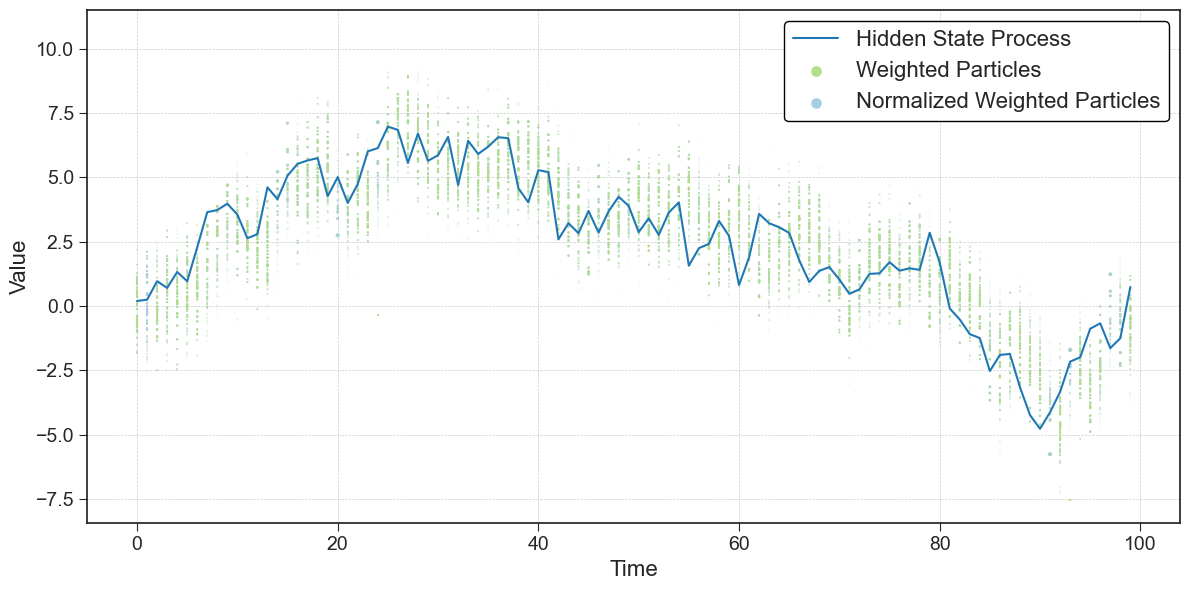

In [118]:
# Plot BPF weighted particles vs hidden state process

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(X_real, color=colors[1], label='Hidden State Process')

for t in range(T):
    if t == 1: 
        plt.scatter([t] * particles.shape[0], particles[:, t], s=weights[:, t], marker='o', color=colors[2], label='Weighted Particles')
        plt.scatter([t] * particles.shape[0], particles[:, t], s=norm_weights[:, t]*10, marker='o', color=colors[0], label='Normalized Weighted Particles')
    else:
        plt.scatter([t] * particles.shape[0], particles[:, t], s=norm_weights[:, t]*10, marker='o', color=colors[0])
        plt.scatter([t] * particles.shape[0], particles[:, t], s=weights[:, t], marker='o', color=colors[2])
        
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=15)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

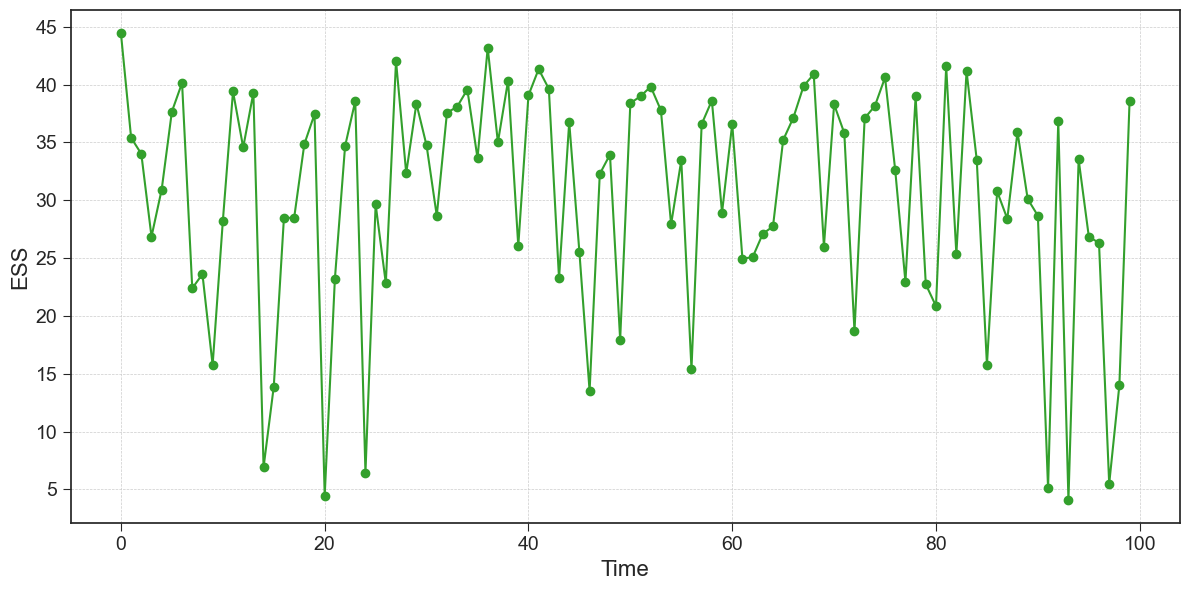

In [119]:
# Plot the ESS for the BPF results
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(ESS, color=colors[3], marker='o')
        
plt.xlabel('Time', fontsize=16)
plt.ylabel('ESS', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [120]:
########################################################
######### Adaptative Bootstrap Particle Filter #########
########################################################


# Define number of particles
num_particles = 50
# Initialize varibles
weights = np.zeros((num_particles, T))
norm_weights = np.zeros((num_particles, T)) 
particles = np.zeros((num_particles,T))
resampled_particles = np.zeros((num_particles,T))
#Initialize ESS
ESS = np.zeros(T)
#Initialize estimated states

estimated_states = np.zeros(T)
estimated_log_marginals = np.zeros(T)
ancestry_matrix = np.zeros((num_particles,T))

# Time t=1
particles[:,0] = stats.norm(0,1).rvs(size=num_particles)
weights[:,0] = stats.norm(particles[:,0],1).pdf(Y_obs[0])
norm_weights[:,0] = weights[:,0] / weights[:,0].sum()
ESS[0] = 1 / (norm_weights[:,0]**2).sum()

estimated_states[0] = np.sum(particles[:, 0]*norm_weights[:,0])
estimated_log_marginals[0] = np.log(np.sum(weights[:,0])) - np.log(num_particles)

# Resampling
if ESS[0] < 0.5*num_particles: 
    ancestry_matrix[:,0], resampled_particles[:,0] = systematic_resampling(particles[:,0], norm_weights[:,0])
    weights[:,0] = np.ones(num_particles) / num_particles
else:
    ancestry_matrix[:,0] = np.arange(num_particles)
    resampled_particles[:,0] = particles[:,0]

# Time t > 1
for t in range(1,T):
    # Predict step: propagate particles forward using motion model
    particles[:, t] = 0.95*resampled_particles[:, t - 1] + stats.norm(0,1).rvs(num_particles)

    # Update step: compute importance weights based on observation model
    weights[:, t] = weights[:, t-1]*stats.norm(particles[:,t],1).pdf(Y_obs[t])
    norm_weights[:, t] = weights[:,t] / weights[:,t].sum()
    ESS[t]= 1 / np.sum(norm_weights[:, t]**2)

    estimated_states[t] = np.sum(particles[:, t]*norm_weights[:,t])
    estimated_log_marginals[t] = np.log(np.sum(weights[:,t])) - np.log(num_particles)
    
    # Resampling
    if ESS[t] < 0.9*num_particles:
        ancestry_matrix[:,t], resampled_particles[:,t] = systematic_resampling(particles[:,t], norm_weights[:,t])
        weights[:,t] = np.ones(num_particles) / num_particles
    else:
        ancestry_matrix[:,t] = np.arange(num_particles)
        resampled_particles[:,t] = particles[:,t]

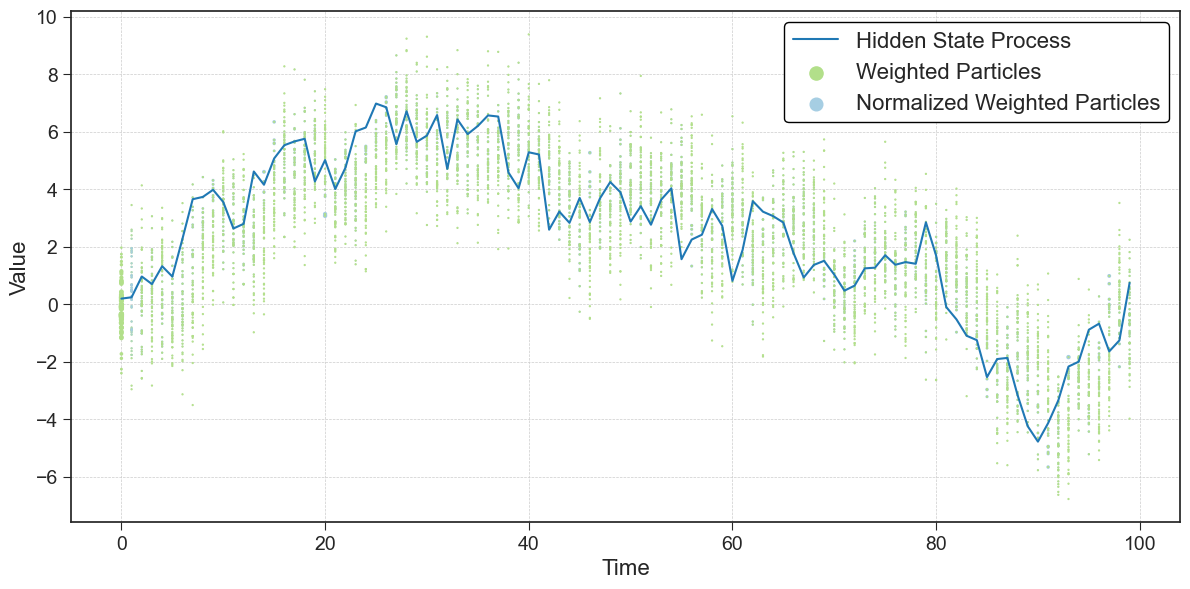

In [128]:
# Plot the Adaptative BPF weighted particles vs hidden state process

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(X_real, color=colors[1], label='Hidden State Process')

for t in range(T):
    if t == 1: 
        plt.scatter([t] * particles.shape[0], particles[:, t], s=weights[:, t]*20, marker='o', color=colors[2], label='Weighted Particles')
        plt.scatter([t] * particles.shape[0], particles[:, t], s=norm_weights[:, t]*15, marker='o', color=colors[0], label='Normalized Weighted Particles')
    else:
        plt.scatter([t] * particles.shape[0], particles[:, t], s=norm_weights[:, t]*15, marker='o', color=colors[0])
        plt.scatter([t] * particles.shape[0], particles[:, t], s=weights[:, t]*20, marker='o', color=colors[2])
        
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(
    loc='upper right',
    fontsize=16, 
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white',
    markerscale=15)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

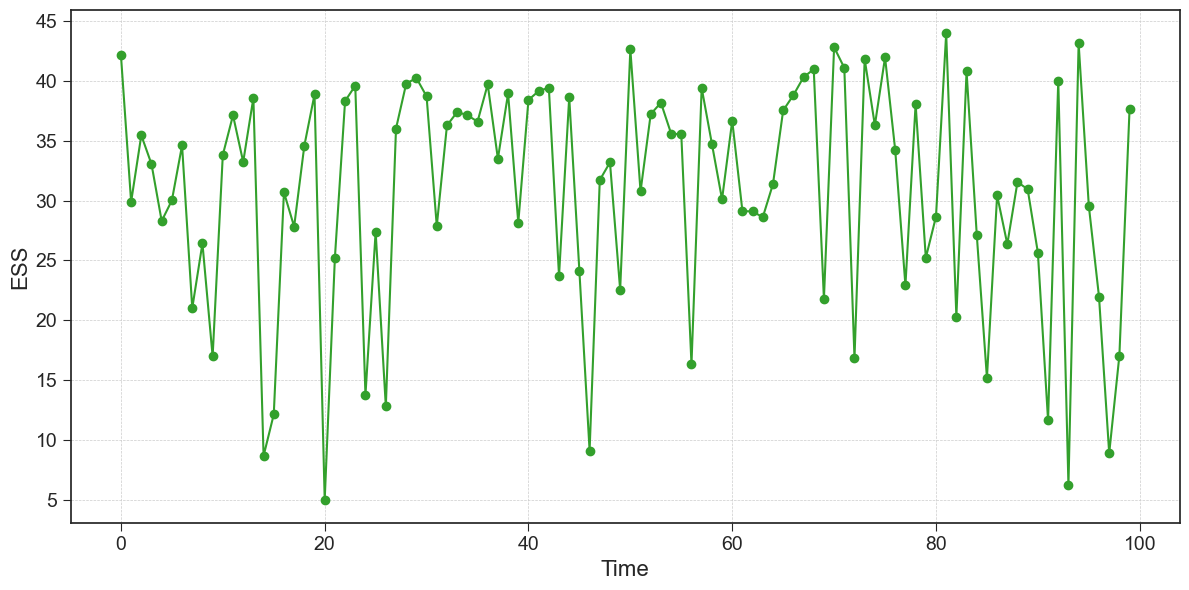

In [129]:
# Plot the ESS for the Adaptative BPF results
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(ESS, color=colors[3], marker='o')
        
plt.xlabel('Time', fontsize=16)
plt.ylabel('ESS', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()